In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import cv2
import torch as t

root = os.getcwd()
dir = 'tiny_vid'
root = os.path.join(root,dir)
data_dir = []
label_dir = []
for each in os.listdir(root):
    if '.txt' in each:
        label_dir.append(each)
    elif '.md' not in each:
        data_dir.append(each)
data_dir,label_dir

(['bird', 'car', 'dog', 'lizard', 'turtle'],
 ['bird_gt.txt', 'car_gt.txt', 'dog_gt.txt', 'lizard_gt.txt', 'turtle_gt.txt'])

In [3]:
img_path = []
bbox_path = []
for each in data_dir:
    for img in os.listdir(os.path.join(root,each))[:180]:
        img_path.append(os.path.join(os.path.join(root,each),img))
        
for each in label_dir:
    bbox_path.append((os.path.join(root,each)))
len(img_path)

900

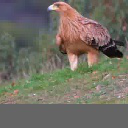

In [4]:
Image.open(img_path[0])

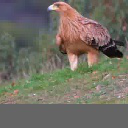

In [5]:
imgs = [Image.open(i)for i in img_path]
imgs[0]

In [6]:
l1 = np.zeros((180,))
l2 = np.ones((180,))
l3 = l2.copy()*2
l4 = l2.copy()*3
l5 = l2.copy()*4

labels = np.concatenate((l1,l2,l3,l4,l5))
labels = t.from_numpy(labels)
labels.size()

torch.Size([900])

In [7]:
for each in bbox_path:
    if each == bbox_path[0]:
        bbox_data = pd.read_csv(each,sep=' ',header=None,index_col=None)
        bbox_data[0] -= 1
        bbox_data = bbox_data.iloc[:180]
        bbox_data = bbox_data.drop(0,axis=1)
        bbox_data = bbox_data.values
    else:
        data = pd.read_csv(each,sep=' ',header=None,index_col=None)
        data[0]-=1
        data = data.iloc[:180]
        data = data.drop(0,axis=1)
        data = data.values
        bbox_data = np.concatenate((bbox_data,data),axis=0)
bbox_data
# bbox_data = t.from_numpy(bbox_data)
# bbox_data.size()

array([[ 46,   0, 123,  70],
       [  4,  17,  84,  83],
       [ 14,  13, 105,  99],
       ...,
       [ 13,  38,  94,  82],
       [ 13,   4, 100,  63],
       [  2,   7, 127, 125]], dtype=int64)

In [10]:
bbox_w = bbox_data[:,2]-bbox_data[:,0]
bbox_h = bbox_data[:,3]-bbox_data[:,1]
bbox_h,bbox_w

(array([ 70,  66,  86, 111,  92,  49,  35,  88, 113,  87, 121,  84,  98,
        117, 111,  78,  80,  81, 121, 114,  93,  62,  57, 122,  31, 103,
         89, 114,  64,  76,  90,  56,  80, 128,  34,  79,  62,  56,  77,
        104,  89, 112,  46,  89, 127,  63,  89, 104,  70,  75,  46,  40,
         35,  50,  63,  90,  30,  61, 128,  96,  32,  93,  47, 110,  56,
         97, 119, 114,  99, 105,  57,  37,  99,  55,  99, 108, 114,  46,
         30, 118,  44,  89, 106,  53, 123,  93, 101, 117,  66,  47,  67,
         36, 101, 122,  54,  66,  35,  77,  53,  69, 126,  88, 124,  94,
        127,  54, 121, 113,  83,  79,  45,  66,  91,  36,  89, 103,  53,
         99, 127,  85,  34,  52,  71,  98, 126,  57, 105,  67,  36,  38,
         97, 100,  38, 123,  80,  36, 106, 108,  69,  67,  90,  46,  35,
        122,  82,  47, 124,  54,  67,  46,  90,  88,  55, 110,  50,  80,
         71,  73,  65, 108,  75,  31, 113, 115, 106, 128,  32, 122,  73,
         48, 122, 107, 124, 121,  65,  77, 119, 127

In [9]:
bbox_hw = np.stack((bbox_h,bbox_w),axis=1)
bbox_hw

array([[ 70,  77],
       [ 66,  80],
       [ 86,  91],
       ...,
       [ 44,  81],
       [ 59,  87],
       [118, 125]], dtype=int64)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


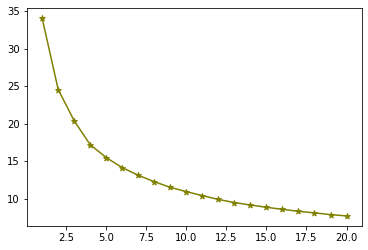

In [37]:
from scipy.cluster.vq import kmeans

seed = 729608
np.random.seed(seed)
iter_time = 100
k_list = list(range(1,21,1))
distortion_list = []
centroid_list = []
for k in k_list:
    centroid,distortion = kmeans(obs=bbox_hw.astype(np.float32),k_or_guess=k,iter=iter_time)
    centroid_list.append(centroid)
    distortion_list.append(distortion)

plt.figure()
plt.scatter(np.array(k_list),np.array(distortion_list),marker='*',c=[0.5,0.5,0.])
plt.plot(np.array(k_list),np.array(distortion_list),c=[0.5,0.5,0.])
plt.show()

In [38]:
k_selected = 3
centroid = centroid_list[k_selected-1]
centroid

array([[101.30232 ,  65.9907  ],
       [ 84.436264, 106.35694 ],
       [ 48.126507,  66.313255]], dtype=float32)

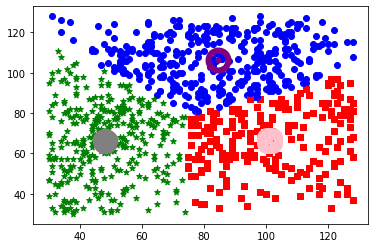

In [56]:
plt.figure()
color_list = ['red','blue','green']
marker_list = ['s','o','*']
color_list2 = ['pink','purple','gray']


distance_0 = np.power(bbox_hw - centroid[0].reshape(1,2),2).sum(axis=1,keepdims=True)
distance_1 = np.power(bbox_hw - centroid[1].reshape(1,2),2).sum(axis=1,keepdims=True)
distance_2 = np.power(bbox_hw - centroid[2].reshape(1,2),2).sum(axis=1,keepdims=True)

distance_matrix = np.concatenate((distance_0,distance_1,distance_2),axis=1)
min_indices = distance_matrix.argmin(axis=1)

for idx in range(bbox_hw.shape[0]):
    plt.scatter(bbox_hw[idx,0],bbox_hw[idx,1],marker=marker_list[min_indices[idx]],color = color_list[min_indices[idx]],linewidth=1)

for i in range(3):
    plt.scatter(centroid[i,0],centroid[i,1],marker=marker_list[i],linewidth=20,color=color_list2[i])

plt.show()